In [1]:
import pandas as pd

In [6]:
complaints = pd.read_csv('complaints.csv')

In [7]:
import re

complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(lambda x: re.sub(r'XX', '', x))


In [8]:
complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(lambda x: re.sub(r'//', '', x))


In [9]:
complaints['category_id'] = complaints['Issue'].factorize()[0]
category_id_df = complaints[['Issue', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Issue']].values)
complaints.head()

,Consumer complaint narrative,Issue,category_id
0,My name is this complaint is not made in err...,Incorrect information on your report,0
1,I searched on for and was pointed to a web...,Fraud or scam,1
2,I have a particular account that is stating th...,Incorrect information on your report,0
3,I have not supplied proof under the doctrine o...,Attempts to collect debt not owed,2
4,Hello i'm writing regarding account on my cred...,Incorrect information on your report,0


In [10]:
complaints['Issue'].value_counts()

Incorrect information on your report    229305
Attempts to collect debt not owed        73163
Communication tactics                    21243
Struggling to pay mortgage               17374
Fraud or scam                            12347
Name: Issue, dtype: int64

In [11]:
# list of words to remove from 'Incorrect information on your report'
words_to_remove = ['bankruptcy', 'filed', 'file', 'card', 'cards', 'loan', 'loans', 'month', 'stop', 'calling','collect','debt', 'navient']

# convert text to lowercase
complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].str.lower()

# Filter the words
mask = complaints['Issue'] == 'Incorrect information on your report'
complaints.loc[mask, 'Consumer complaint narrative'] = complaints.loc[mask, 'Consumer complaint narrative'].apply(
    lambda text: ' '.join([word for word in text.split() if word not in words_to_remove])
)

In [12]:
# list of words to remove from 'Attempts to collect debt not owed'
words_to_remove2 = ['navient', 'midland', 'hospital', 'consumer', 'pursuant', 'portfolio', 'recovery', 'mcm', 'month', 'usc', 'hung', 'transworld']

# filter the words
mask = complaints['Issue'] == 'Attempts to collect debt not owed'
complaints.loc[mask, 'Consumer complaint narrative'] = complaints.loc[mask, 'Consumer complaint narrative'].apply(
    lambda text: ' '.join([word for word in text.split() if word not in words_to_remove2])
)

In [13]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X = complaints['Consumer complaint narrative']
y = complaints['Issue']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
X_test_vec = fitted_vectorizer.transform(X_test)
svc = LinearSVC()
svc.fit(tfidf_vectorizer_vectors, y_train)
y_pred = svc.predict(X_test_vec)
print(classification_report(y_test, y_pred))

                                      precision    recall  f1-score   support

   Attempts to collect debt not owed       0.87      0.83      0.85     18412
               Communication tactics       0.86      0.79      0.83      5257
                       Fraud or scam       0.95      0.89      0.92      3122
Incorrect information on your report       0.95      0.98      0.96     57230
          Struggling to pay mortgage       0.95      0.95      0.95      4337

                            accuracy                           0.93     88358
                           macro avg       0.92      0.89      0.90     88358
                        weighted avg       0.93      0.93      0.93     88358



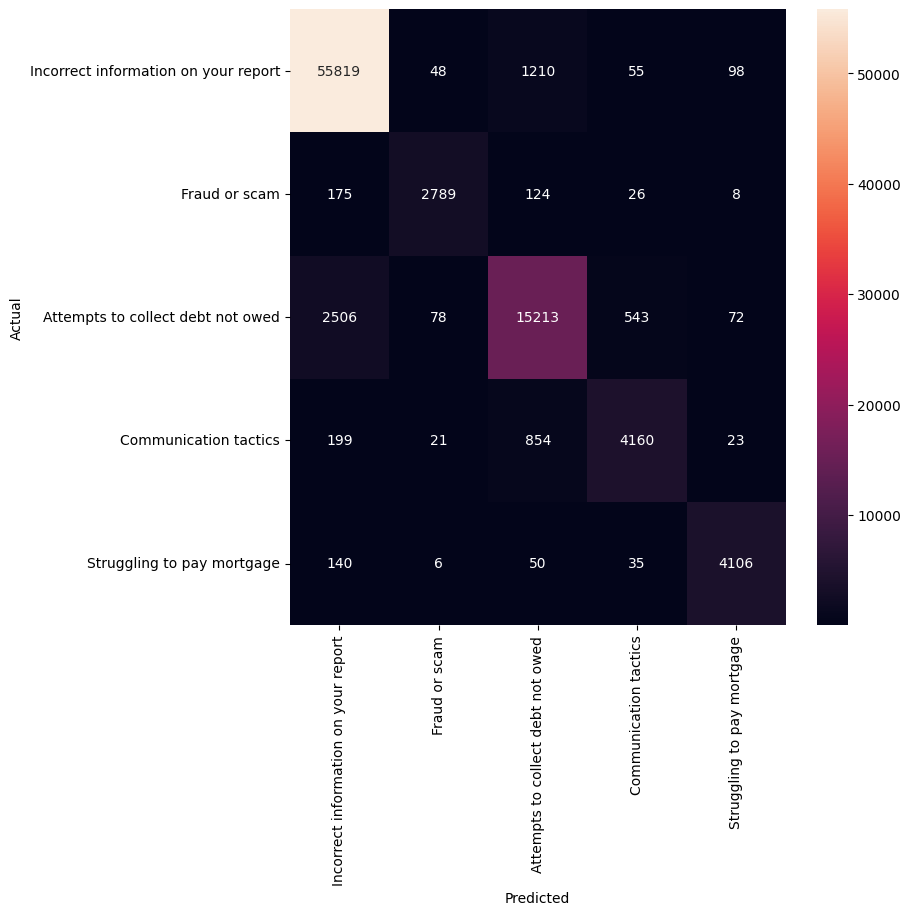

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Set categories of issue column to match label_df
complaints['Issue'] = pd.Categorical(complaints['Issue'], categories=category_id_df['Issue'])

# Factorize issue column
complaints['category_id'] = complaints['Issue'].cat.codes

conf_mat = confusion_matrix(y_test, y_pred, labels=category_id_df['Issue'].tolist())

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Issue.values, yticklabels=category_id_df.Issue.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()